# 0. Computer vision libraries in PyTroch
- `torchvision` - base domain library for PyTroch computer vision
- `torchvision.dataset` - det datasets and data loading functions for computer vision
- `torchvision.models` - get pretrained computer vision models
- `torchvision.transforms` - function for manipulating your vision data (images) to be suitable for use
- `torch.utils.data.Dataset` - Base dataset class for PyTroch
- `torch.utils.data.DataLoader` - Creates a Python iterable over datasets

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset,DataLoader

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

# 1. Getting a dataset

We will use FashionMNIST Data set - https://pytorch.org/vision/0.19/generated/torchvision.datasets.FashionMNIST.html

In [ ]:
# Setup Training data
train_data = datasets.FashionMNIST(
    root = 'data', # Where to downlaod the data
    train = True,  # do we want the training dataset?
    download = True, # do we want to downlaod the data ?
    transform = torchvision.transforms.ToTensor(), # how do we transform the data/train
    target_transform = None # how do we transform the labels/target
)

# Setup Testing data
test_data = datasets.FashionMNIST(
    root = 'data',
    train = False, # choose the test version of the data
   download = True,
    transform = ToTensor(),
    target_transform= None
)

100%|██████████| 26.4M/26.4M [00:02<00:00, 12.9MB/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 200kB/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.76MB/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 21.2MB/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [ ]:
len(train_data), len(test_data)

(60000, 10000)

In [ ]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

## 1.1 Visualizing our data

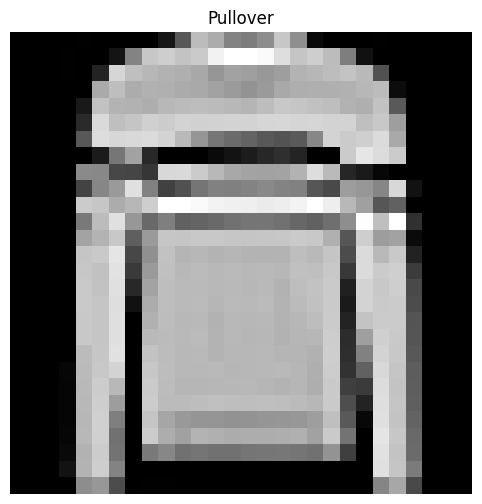

In [ ]:
index = 5 # try different index values less than 60,000
image, label = train_data[index]

plt.figure(figsize=(8,6))
plt.imshow(image.squeeze(dim=0),cmap='gray')
plt.title(f'{class_names[label]}')
plt.axis(False)
plt.show()

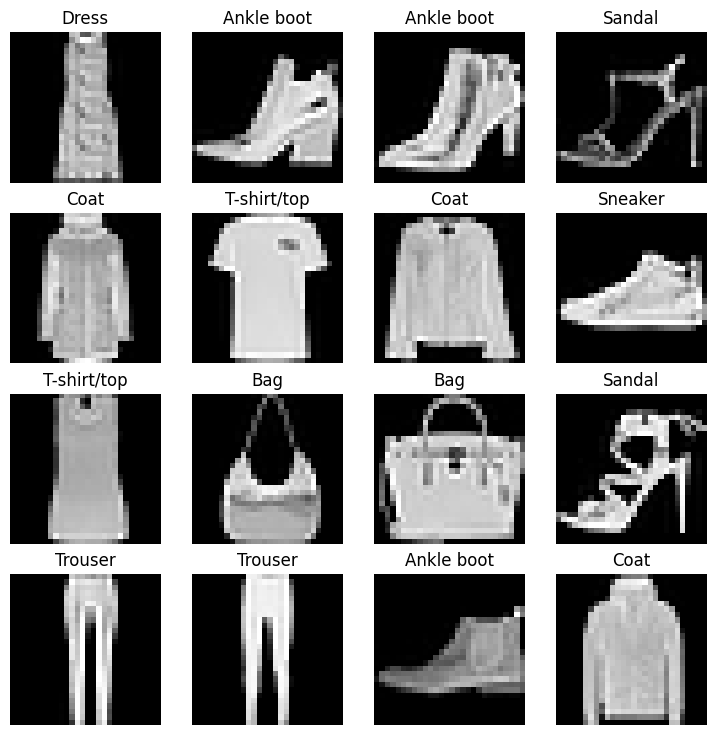

In [ ]:
# Plot more images
def show_samples(data: torch.utils.data.Dataset):
  class_names = data.classes
  fig = plt.figure(figsize=(9,9))
  rows, cols = 4,4
  for i in range(1,rows*cols + 1):
    random_idx = torch.randint(0,len(data), size=[1]).item()
    img, label = data[random_idx]
    fig.add_subplot(rows,cols,i)
    plt.imshow(img.squeeze(dim=0),cmap='gray')
    plt.title(class_names[label])
    plt.axis(False)

show_samples(train_data)

# 2. Prepare DataLoader

DataLoader turns our dataset into Python iterable

In [ ]:
# Setup some hyperparameters
batch_size = 32
num_workers = 2

train_dataloader = DataLoader(dataset=train_data,
                              batch_size = batch_size,
                              num_workers=num_workers,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size = batch_size,
                             num_workers = num_workers,
                             shuffle=False) # optional here

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7e4ac2f55fd0>,
 <torch.utils.data.dataloader.DataLoader at 0x7e4ac2f048d0>)

In [ ]:
print(f'Length of train_dataloader {len(train_dataloader)} batches of {batch_size}')
print(f'Length of test_dataloader {len(test_dataloader)} batches of {batch_size}')

Length of train_dataloader 1875 batches of 32
Length of test_dataloader 313 batches of 32


We have 1875 batches of 32 images per batch for the training dataloader

if we have 5 epohcs the model will go throug 5 * 1875 iterations

In [ ]:
train_features_batch, train_label_batch = next(iter(train_dataloader))
train_features_batch.shape, train_label_batch.shape
# the train batch will have the shape of [N,C,H,W]
# N -> number of samples per batch
# C -> color channels
# H -> Height of the image
# W -> Width of the image

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

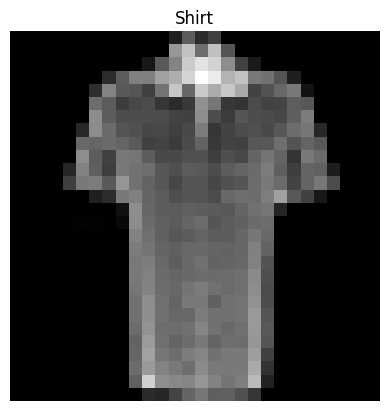

Image shape torch.Size([1, 28, 28])


In [ ]:
# Show a sample
torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_label_batch[random_idx]
plt.imshow(img.squeeze(dim=0), cmap='gray')
plt.title(class_names[label])
plt.axis(False)
plt.show()
print("Image shape",img.shape)

# 3. Model 0 : Build a baseline model

In [ ]:
class ModelV0(nn.Module):
  """
  This class model is a baseline to test how the linear model will perform on computer vision task
  and also the improve our model with experiments (trail and error)
  """
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int):
    """
    This constructor will instantiate the linear model
    input_shape : the input dimesions of the image afeter flatten [1,-1]
    hideen_units : how many hidden layers between the two linear layers
    output_shpae : the output labels or classes to be predeicted
    """
    super().__init__()
    self.layers = nn.Sequential(
        nn.Flatten(), # to make the shape of the input [1,-1]
        nn.Linear(in_features = input_shape, out_features=hidden_units),
        nn.Linear(in_features= hidden_units, out_features=output_shape)
    )

  def forward(self,x):
    return self.layers(x)

In [ ]:
model_0 = ModelV0(
    input_shape = 28*28, # the shape of the image after flatting
    hidden_units = 10,
    output_shape = len(class_names) # number of labels
).to('cpu')

model_0

ModelV0(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [ ]:
# setup loss function and optimizer

#loss_fn = torch.nn.CrossEntropyLoss()

#optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.01)

# Download helper_function.py
import requests
from pathlib import Path
if Path('helper_functions.py').is_file():
  print("helper_functions.py already exists, skipping download...")
else:
  print("Downloading helper_function.py")
  request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py')
  with open('helper_functions.py', 'wb') as f:
    f.write(request.content)

In [ ]:
from helper_functions import accuracy_fn


In [ ]:
from timeit import default_timer as timer
def print_train_time(start: float,
                     end: float,
                     device = None):
  """Prints the difference between start and end time of the training loop"""
  total_time = end - start
  print(f'Train time on {device}: {total_time:.3f} seconds')
  return total_time

In [ ]:
start_time = timer()
for i in range(10000):
  pass
end_time = timer()
total = print_train_time(start_time, end_time)
total

Train time on None: 0.001 seconds


0.0007420660000434509

## 3.3  Creating a training loop and training a model on batches of data
1. Loop through epochs
2. Loop through training batches, perform training steps, calculate the train loss *per batch*
3. Lopp through testing batches, perform testing steps, calculate the loss *per batch*

In [ ]:
from tqdm.auto import tqdm

# Set the seed and start the timer
torch.manual_seed(42)
train_time_start_on_cpu = timer()

# Set the number of epochs
epochs = 3

# create a tarining and testing loop

for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n----")
  ### Training
  train_loss = 0

  # Add a loop to loop through the training batches
  for batch, (X,y) in enumerate(train_dataloader):
    model_0.train()
    # 1. Forward pass
    y_pred = model_0(X)

    # 2. calculate the loss
    loss = loss_fn(y_pred,y)
    train_loss += loss.item() # accumulate train loss over the batch

    # 3. optimzer zero grad
    optimizer.zero_grad()

    # 4. loss backward -> backpropagation
    loss.backward()

    # 5. optimizer step -> update the weights
    optimizer.step()

    # print what is happening
    if batch % 400 == 0:
      print(f'Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples.')

  # Divide the total train loss by length of train data loader
  train_loss /= len(train_dataloader)

  ### Testing
  test_loss, test_acc = 0, 0
  model_0.eval()
  with torch.inference_mode():
    for X,y in test_dataloader:
      # 1. Forward padd
      y_pred_test = model_0(X)

      # 2. calculate the loss
      loss_tset = loss_fn(y_pred_test,y)
      test_loss += loss_tset.item()

      # 3. calculate the accuracy
      test_acc += accuracy_fn(y_true=y, y_pred=y_pred_test.argmax(dim=1))

    # calculate the test loss average per batch
    test_loss /= len(test_dataloader)

    # calculate the test accuracy average per batch
    test_acc /= len(test_dataloader)

  print(f'\n Epoch: {epoch} | Train loss: {train_loss:.4f} | Test loss: {test_loss:.4f} | Test accuracy: {test_acc:.4f}')

# caculate the training time
train_time_end_on_cpu = timer()
print_train_time(train_time_start_on_cpu,
                 train_time_end_on_cpu,
                 device= 'cpu')

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
----
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.

 Epoch: 0 | Train loss: 0.9144 | Test loss: 0.6350 | Test accuracy: 78.4345
Epoch: 1
----
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.

 Epoch: 1 | Train loss: 0.5647 | Test loss: 0.5478 | Test accuracy: 81.2001
Epoch: 2
----
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.

 Epoch: 2 | Train loss: 0.5076 | Test loss: 0.5179 | Test accuracy: 81.8391
Train time on cpu: 39.389 seconds


39.38884257699999

# 4. Create an evaluation function

In [ ]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn):
  """Returns a dictionary containing the results of model predicting on data_loader"""
  loss,acc = 0,0
  model.eval()
  with torch.inference_mode():
    for X,y in tqdm(data_loader):
      # Make predictions
      y_pred = model(X)

      # Accumulate the loss and acc values per batch
      loss += loss_fn(y_pred, y)
      acc += accuracy_fn(y,y_pred.argmax(dim=1))

    # Scale loss and acc to find the average loss/acc per batch
    loss /= len(data_loader)
    acc /= len(data_loader)

  return {'loss': loss.item(), 'accuracy': acc}

# Calculate model_0 resutls on test dataset
model_0_results = eval_model(model_0,test_dataloader,loss_fn,accuracy_fn)
print(f'Loss: {model_0_results["loss"]:.4f} | accuracy: {model_0_results["accuracy"]:.4f}')

  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 0.5179 | accuracy: 81.8391


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

# 4. Create a model with linear and non-linear layers

In [ ]:
class ModelV1(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features= input_shape, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_shape),
        nn.ReLU()
    )

  def forward(self,x : torch.Tensor):
    return self.layers(x)


torch.manual_seed(42)
model_1 = ModelV1(
    input_shape = 28*28,
    hidden_units = 10 ,
    output_shape = len(class_names)
).to(device)

model_1

ModelV1(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=10, bias=True)
    (4): ReLU()
  )
)

In [ ]:
# loss function and optimizer

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(params=model_1.parameters() , lr=0.01)

accuracy = accuracy_fn


# 5. Create training and evaluation function

In [ ]:
from tqdm.auto import tqdm
from typing import Callable
import torch
from torch import nn
import torchvision
from torch.utils.data import Dataset,DataLoader


def fit_model(
    model: torch.nn.Module,
    train_loader: torch.utils.data.DataLoader,
    test_loader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    accuracy_fn: Callable[[torch.Tensor, torch.Tensor], float],
    device = torch.device('cpu'),
    epochs : int = 10,
    print_values :bool = True,
    plot_loss: bool = True
):
  """
  This function is going to train the model on the givin train_loader, calculate the loss and optimize the parameters,
  optional : can print the values of the loss and accuracy

  Args:
  model: a troch.nn.Module model to be traind * this only works for class models not predifined models *
  train_loader: a troch.utils.data.DataLoader to train and fit the module on
  test_loader: a torch.utils.data.DataLoader to test the accuracy and the performanse of the mdoule
  loss_fn: measures how wrong the model is perfoming on the givin data
  optimizer: torch.optim.Opimizer to update the paramters of the model to reduce the loss_fn
  accuracy_fn: *Optional* python function to calculate the error of the model with parameters (y_true,y_pred)
  device: *Optional* set the device to 'cpu' or 'cuda'default is 'cpu
  epcohs: *Optional* the number of outer loop 'epochs' how many iterations on the whole data set, defualt is 10
  print_values: *Optional* wither to print the values of the loss and error or not, default is True
  plot_loss : *Optional* plot line curves of the train and test loss behavior
  """

  model.train()
  train_losses = []
  test_losses = []

  for epoch in tqdm(range(epochs), desc='Training and Testing progress: '):

    print(f"Epoch: {epoch}\n----------")
    train_loss,train_acc = 0,0
    ### Training loop
    for batch, (X,y) in tqdm(enumerate(train_loader), desc='Number of examples: '):
      # moveing the data to the target device
      X,y = X.to(device), y.to(device)

      # make predections *Forward pass*
      y_logits = model(X)

      # calculate the loss and accuracy
      loss = loss_fn(y_logits,y)
      train_acc += accuracy_fn(y,y_logits.argmax(dim=1))
      train_loss += loss.item()

      # optimizer zero grad
      optimizer.zero_grad()
      # loss backward *Backpropagation*
      loss.backward()
      # optimizer step
      optimizer.step()


    train_loss /= len(train_loader)
    train_acc /= len(train_loader)

    ### Testing
    test_loss, test_acc = 0,0
    model.eval()
    with torch.inference_mode():
      for X_test,y_test in test_loader:
        X_test,y_test = X_test.to(device), y_test.to(device)
        y_test_logits = model(X_test)

        loss_test = loss_fn(y_test_logits, y_test)

        test_loss += loss_test.item()
        test_acc += accuracy_fn(y_test, y_test_logits.argmax(dim=1))

      test_loss /= len(test_loader)
      test_acc /= len(test_loader)

      train_losses.append(train_loss)
      test_losses.append(test_loss)

    if print_values:
      print(f"Epoch: {epoch+1} | Train Loss {train_loss:.4f} | Train accuracy: {train_acc:.4f}% | Test Loss {test_loss:.4f} | Test accuracy: {test_acc:.4f}%\n")

  if plot_loss:
    plt.figure(figsize=(8,8))
    plt.plot(range(epochs), train_losses, color='blue',label='train loss')
    plt.plot(range(epochs), test_losses, color='green', label='test loss')
    plt.title('Train and Test Loss curves')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()






In [ ]:
fit_model(model_1.to(device),train_dataloader,test_dataloader,loss_fn,optimizer,accuracy_fn,device,epochs=5)

Training and Testing progress:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
----------


Number of examples: : 0it [00:00, ?it/s]

Epoch: 1 | Train Loss 0.4329 | Train accuracy: 84.4933% | Test Loss 0.5042 | Test accuracy: 82.8874%

Epoch: 1
----------


Number of examples: : 0it [00:00, ?it/s]

Epoch: 2 | Train Loss 0.4329 | Train accuracy: 84.4933% | Test Loss 0.5042 | Test accuracy: 82.8874%

Epoch: 2
----------


Number of examples: : 0it [00:00, ?it/s]

Epoch: 3 | Train Loss 0.4329 | Train accuracy: 84.4933% | Test Loss 0.5042 | Test accuracy: 82.8874%

Epoch: 3
----------


Number of examples: : 0it [00:00, ?it/s]

Epoch: 4 | Train Loss 0.4329 | Train accuracy: 84.4933% | Test Loss 0.5042 | Test accuracy: 82.8874%

Epoch: 4
----------


Number of examples: : 0it [00:00, ?it/s]

Epoch: 5 | Train Loss 0.4329 | Train accuracy: 84.4933% | Test Loss 0.5042 | Test accuracy: 82.8874%



In [ ]:
def train_step(
    model: torch.nn.Module,
    data_loader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    accuracy_fn: Callable,
    device = 'cuda'
):
  train_loss, train_acc = 0,0

  model.train()

  for batch, (X,y) in enumerate(data_loader):
    X,y = X.to(device), y.to(device)

    y_pred = model(X)

    loss = loss_fn(y_pred, y)
    train_loss += loss
    train_acc += accuracy(y,y_pred.argmax(dim=1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f'Tarin loss: {train_loss:.4f} | Train acc: {train_acc:.4f}%')



In [ ]:
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device = 'cuda'):
  test_loss, test_acc = 0,0
  model.eval()

  with torch.inference_mode():
    for X,y in data_loader:
      X, y = X.to(device), y.to(device)

      test_pred = model(X)
      test_loss += loss_fn(test_pred, y)
      test_acc += accuracy_fn(y,test_pred.argmax(dim=1))

    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    print(f'Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}%\n')

In [ ]:
epochs = 3

for epoch in tqdm(range(epochs), desc='Trainig and Testing progress'):
  print(f'Epoch: {epoch}\n-------------')
  train_step(model_1, train_dataloader,loss_fn,optimizer,accuracy_fn,device)
  test_step(model_1,test_dataloader,loss_fn,accuracy_fn,device)

Trainig and Testing progress:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------------
Tarin loss: 0.4782 | Train acc: 83.0733%
Test loss: 0.5298 | Test acc: 81.7392%

Epoch: 1
-------------
Tarin loss: 0.4707 | Train acc: 83.3400%
Test loss: 0.5565 | Test acc: 81.3998%

Epoch: 2
-------------
Tarin loss: 0.4638 | Train acc: 83.3950%
Test loss: 0.5042 | Test acc: 82.8874%



# 4. Create a convolutional neural network

In [ ]:
torch.manual_seed(42)
class CNNModuleV2(nn.Module):
  def __init__(self,input_shape, hidden_units, output_shape):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape, # this referes to the number of collor channels [1,3]
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size = 3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = hidden_units*7*7,
                  out_features=output_shape)
    )

  def forward(self,x):
    x = self.conv_block_1(x)
    #print(f'shape of x after conv_block_1: {x.shape}')
    x = self.conv_block_2(x)
    #print(f'shape of x after conv_block_2: {x.shape}')
    x = self.classifier(x)
    #print(f'shape of x after classifier: {x.shape}')
    return x

In [ ]:
# testing what the Conv2d layer is doing to the shape of the picture
torch.manual_seed(42)
Images = torch.randn(size=[32,3,64,64])
test_image = Images[0]
print(f'batch Images shape: {Images.shape}')
print(f'Single image shape: {test_image.shape}')
conv_layer = nn.Conv2d(in_channels=3,
                       out_channels=10,
                       kernel_size=3,
                       stride=1,
                       padding=1)
conv_output = conv_layer(test_image)
print(f'output shape: {conv_output.shape}')

batch Images shape: torch.Size([32, 3, 64, 64])
Single image shape: torch.Size([3, 64, 64])
output shape: torch.Size([10, 64, 64])


In [ ]:
# testing what the MaxPool2d layer is doing to the shape of the picture
max_pool_layer = nn.MaxPool2d(kernel_size=2)
print(f"The original shape of the image: {test_image.shape}\n") # origianl shape [3,64,64]
conv_output = conv_layer(test_image)
# calculate the shape using new shape = ((f + 2p - k) / s ) + 1 ::: Where
# f => the original shape of the image (64)
# p => padding of the layer (1)
# k => size of the kernal (3)
# s => stride of the layer (1)

print(f'Image after going through conv_layer: {conv_output.shape}\n')
max_output = max_pool_layer(conv_output)
print(f'Image after going through max_pool_layer: {max_output.shape}\n')


The original shape of the image: torch.Size([3, 64, 64])

Image after going through conv_layer: torch.Size([10, 64, 64])

Image after going through max_pool_layer: torch.Size([10, 32, 32])



## 4.1 Setup loass function and optimizer and creating training and testing loop

In [ ]:
train_data = datasets.FashionMNIST(
    root = 'data', # Where to downlaod the data
    train = True,  # do we want the training dataset?
    download = True, # do we want to downlaod the data ?
    transform = torchvision.transforms.ToTensor(), # how do we transform the data/train
    target_transform = None # how do we transform the labels/target
)

# Setup Testing data
test_data = datasets.FashionMNIST(
    root = 'data',
    train = False, # choose the test version of the data
   download = True,
    transform = ToTensor(),
    target_transform= None
)
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [ ]:
batch_size = 32
num_workers = 2

train_dataloader = DataLoader(dataset=train_data,
                              batch_size = batch_size,
                              num_workers=num_workers,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size = batch_size,
                             num_workers = num_workers,
                             shuffle=False) # optional here

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7e4ac0ae7690>,
 <torch.utils.data.dataloader.DataLoader at 0x7e4ac0ae6a90>)

In [ ]:
from helper_functions import accuracy_fn

device = 'cuda' if torch.cuda.is_available() else 'cpu'
CnnModule = CNNModuleV2(input_shape = 1,
                        hidden_units = 10,
                        output_shape = len(class_names)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=CnnModule.parameters(), lr=0.001)

Training and Testing progress:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
----------


Number of examples: : 0it [00:00, ?it/s]

Epoch: 1 | Train Loss 0.2991 | Train accuracy: 89.2733% | Test Loss 0.3140 | Test accuracy: 89.1374%

Epoch: 1
----------


Number of examples: : 0it [00:00, ?it/s]

Epoch: 2 | Train Loss 0.2780 | Train accuracy: 89.9050% | Test Loss 0.2994 | Test accuracy: 89.5168%

Epoch: 2
----------


Number of examples: : 0it [00:00, ?it/s]

Epoch: 3 | Train Loss 0.2650 | Train accuracy: 90.3383% | Test Loss 0.2871 | Test accuracy: 90.0359%

Epoch: 3
----------


Number of examples: : 0it [00:00, ?it/s]

Epoch: 4 | Train Loss 0.2539 | Train accuracy: 90.7083% | Test Loss 0.3019 | Test accuracy: 89.3970%

Epoch: 4
----------


Number of examples: : 0it [00:00, ?it/s]

Epoch: 5 | Train Loss 0.2436 | Train accuracy: 91.1833% | Test Loss 0.2781 | Test accuracy: 90.0359%

Epoch: 5
----------


Number of examples: : 0it [00:00, ?it/s]

Epoch: 6 | Train Loss 0.2364 | Train accuracy: 91.3950% | Test Loss 0.2736 | Test accuracy: 90.0958%

Epoch: 6
----------


Number of examples: : 0it [00:00, ?it/s]

Epoch: 7 | Train Loss 0.2276 | Train accuracy: 91.6817% | Test Loss 0.2710 | Test accuracy: 90.2955%

Epoch: 7
----------


Number of examples: : 0it [00:00, ?it/s]

Epoch: 8 | Train Loss 0.2210 | Train accuracy: 91.8967% | Test Loss 0.2613 | Test accuracy: 90.7348%

Epoch: 8
----------


Number of examples: : 0it [00:00, ?it/s]

Epoch: 9 | Train Loss 0.2158 | Train accuracy: 92.1467% | Test Loss 0.2667 | Test accuracy: 90.7248%

Epoch: 9
----------


Number of examples: : 0it [00:00, ?it/s]

Epoch: 10 | Train Loss 0.2112 | Train accuracy: 92.2833% | Test Loss 0.2636 | Test accuracy: 90.5551%



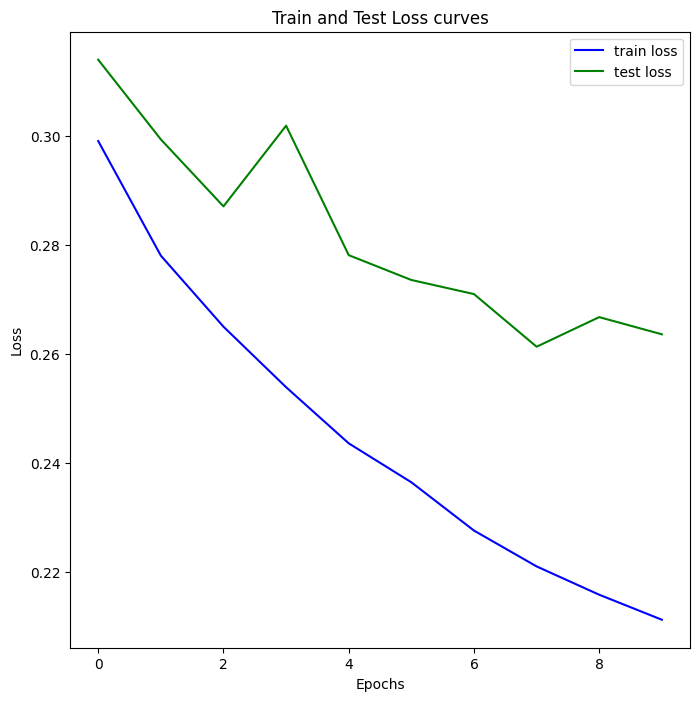

In [ ]:
fit_model(CnnModule,
          train_dataloader,
          test_dataloader,
          loss_fn,
          optimizer,
          accuracy_fn = accuracy_fn,
          device = device,
          epochs = 10)

In [ ]:
import random
def make_predictions(
    model: torch.nn.Module,
    data: list,
    device: torch.device
):
  pred_probs = []
  model.eval()
  with torch.inference_mode():
    for sample in data:
      # prepare sample
      sample = torch.unsqueeze(sample, dim=0).to(device) # add an extra dimension to the smaple

      # Forward pass (make predections)
      pred_logit = model(sample)

      # Get prediction probability (logit -> prediction probability)
      pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

      pred_probs.append(pred_prob.cpu())

  return torch.stack(pred_probs)


def show_samples_after_training(model: torch.nn.Module,
                                test_data: torch.utils.data.Dataset,
                                device: torch.device):
  class_names = test_data.classes
  test_samples = []
  test_labels = []
  for sample, label in random.sample(list(test_data), k=12):
      test_samples.append(sample)
      test_labels.append(label)
  pred_probs = make_predictions(model = model, data = test_samples, device = device)
  pred_classes = pred_probs.argmax(dim=1)

  plt.figure(figsize=(12,12))
  nrows = 4
  ncols = 4
  for i, sample in enumerate(test_samples):
    # Create a subplot
    plt.subplot(nrows, ncols, i+1)

    # Plot the target image
    plt.imshow(sample.squeeze(), cmap="gray") # if this is RGB image remove the .squeeze part and add .permute(1,2,0) C,H,W -> H,W,C

    # Find the prediction label (in text form, e.g. "Sandal")
    pred_label = class_names[pred_classes[i]]

    # Get the truth label (in text form, e.g. "T-shirt")
    truth_label = class_names[test_labels[i]]

    # Create the title text of the plot
    title_text = f"Pred: {pred_label} | Truth: {truth_label}"

    # Check for equality and change title colour accordingly
    if pred_label == truth_label:
        plt.title(title_text, fontsize=10, c="g") # green text if correct
    else:
        plt.title(title_text, fontsize=10, c="r") # red text if wrong
    plt.axis(False);

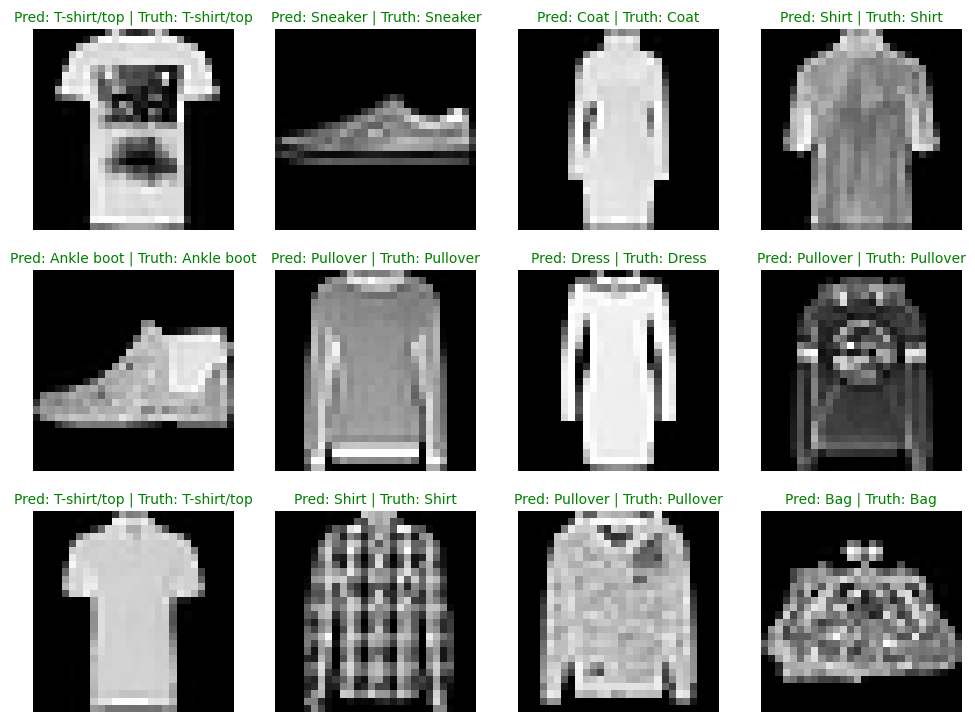

In [ ]:
show_samples_after_training(model=CnnModule,
                            test_data = test_data,
                            device = device)